In [1]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="USD",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params,verify=False).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [2]:
coin_sym_list = 'BTC ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':]  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is be

In [3]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,BTC,ETH,DASH,LTC
time,,,,
2014-01-01,815.94,NaN,NaN,24.77
2014-01-02,856.91,NaN,NaN,26.60
2014-01-03,884.26,NaN,NaN,25.49
2014-01-04,924.69,NaN,NaN,24.05
2014-01-05,1014.74,NaN,NaN,26.01
,BTC,ETH,DASH,LTC
time,,,,
2018-09-25,6437.74,219.20,189.69,57.54
2018-09-26,6462.60,214.21,183.91,57.23


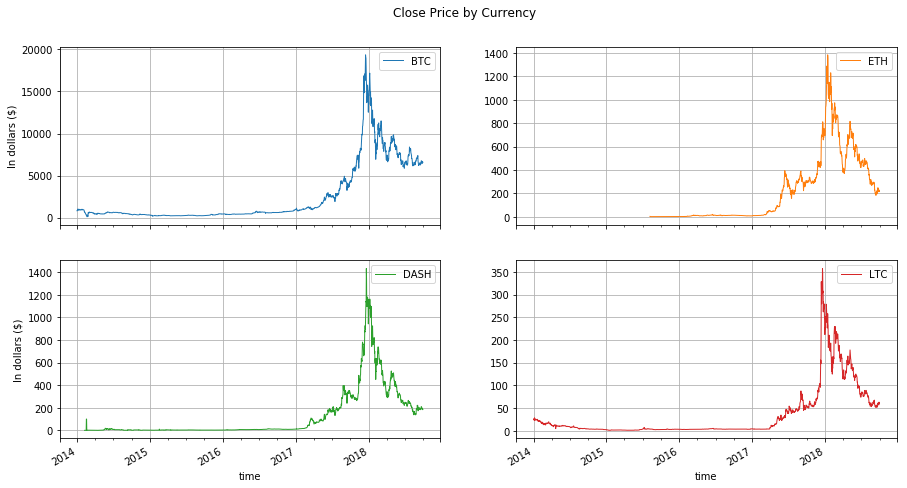

In [4]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [5]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:303: RuntimeWarning: invalid value encountered in hurst_rs
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
BTC,0.577452,0.584657,0.480385
ETH,0.568473,0.625484,0.476510
DASH,0.457173,0.536049,0.514114
LTC,0.566992,0.587203,0.411410


In [6]:
# the same methodology as shown in the paper.
roll_days = 250
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [7]:
roll_hurst[::50].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-02-09  0.652627  0.666953  0.472250  0.639983  0.671151  0.586967   
2018-03-31  0.608464  0.660524  0.458946  0.661077  0.618758  0.624430   
2018-05-20  0.598945  0.661546  0.457014  0.664180  0.605742  0.644974   
2018-07-09  0.592909  0.635206  0.456118  0.681189  0.584495  0.690231   
2018-08-28  0.382779  0.598736  0.424454  0.550117  0.554240  0.644674   

                 LTC            
                DSOD        RS  
time                            
2018-02-09  0.615355  0.615336  
2018-03-31  0.594308  0.632759  
2018-05-20  0.585331  0.601219  
2018-07-09  0.578379  0.614936  
2018-08-28  0.452705  0.499244

In [8]:
roll_hurst[::50].mean()

BTC   DSOD    0.567000
      RS      0.592067
DASH  DSOD    0.344852
      RS      0.519279
ETH   DSOD    0.548899
      RS      0.628856
LTC   DSOD    0.541248
      RS      0.569662
dtype: float64

In [9]:
roll_hurst[::50].median()

BTC   DSOD    0.572176
      RS      0.602955
DASH  DSOD    0.424454
      RS      0.543947
ETH   DSOD    0.550764
      RS      0.644824
LTC   DSOD    0.589820
      RS      0.577123
dtype: float64

In [10]:
roll_hurst[::50].mean(level=0, axis=1);

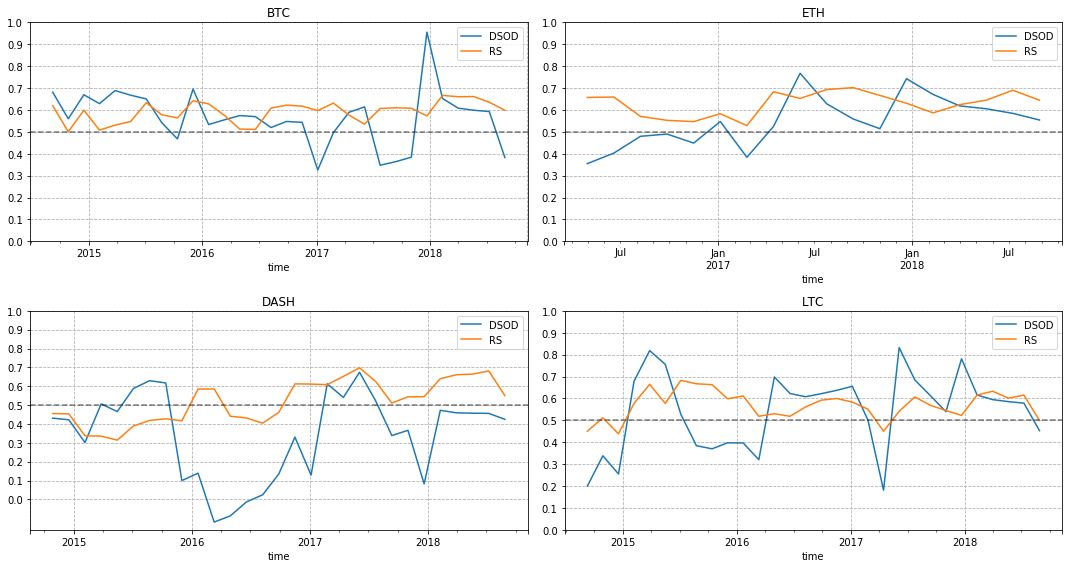

In [11]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [12]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-25  0.415569  0.588791  0.424770  0.581282  0.525405  0.620370   
2018-09-26  0.410823  0.588819  0.422225  0.580603  0.520515  0.618551   
2018-09-27  0.406164  0.588223  0.419614  0.579045  0.515426  0.617115   
2018-09-28  0.402327  0.587201  0.417013  0.577308  0.510461  0.615753   
2018-09-29  0.398344  0.586199  0.414480  0.575424  0.505763  0.614339   

                 LTC            
                DSOD        RS  
time                            
2018-09-25  0.444501  0.528705  
2018-09-26  0.441373  0.527580  
2018-09-27  0.438242  0.526271  
2018-09-28  0.435090  0.524692  
2018-09-29  0.432032  0.523055

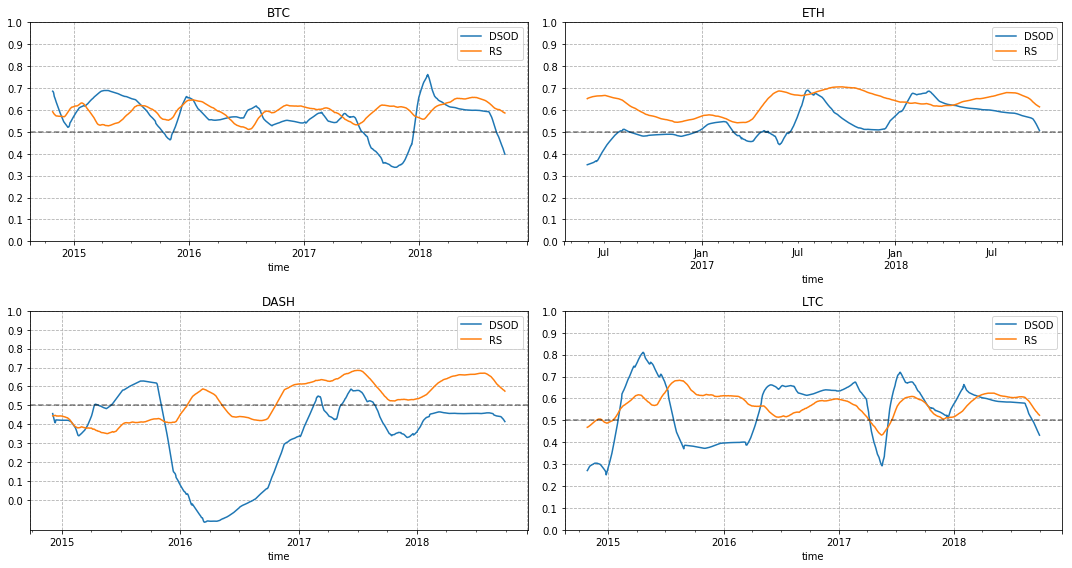

In [13]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [14]:
roll_hurst[::30].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-05-10  0.595555  0.639773  0.457300  0.665599  0.601128  0.648284   
2018-06-09  0.602796  0.666132  0.459570  0.651708  0.601452  0.647326   
2018-07-09  0.592909  0.635206  0.456118  0.681189  0.584495  0.690231   
2018-08-08  0.589538  0.601596  0.459752  0.611813  0.584841  0.668289   
2018-09-07  0.458018  0.619076  0.458155  0.574979  0.550243  0.622008   

                 LTC            
                DSOD        RS  
time                            
2018-05-10  0.584942  0.615456  
2018-06-09  0.584233  0.603186  
2018-07-09  0.578379  0.614936  
2018-08-08  0.579852  0.580711  
2018-09-07  0.479144  0.503579

In [15]:
roll_hurst[::30].mean()

BTC   DSOD    0.567681
      RS      0.595367
DASH  DSOD    0.349185
      RS      0.528083
ETH   DSOD    0.526414
      RS      0.631505
LTC   DSOD    0.537386
      RS      0.569231
dtype: float64

In [16]:
roll_hurst[::30].median()

BTC   DSOD    0.569742
      RS      0.602603
DASH  DSOD    0.434381
      RS      0.545680
ETH   DSOD    0.525381
      RS      0.643716
LTC   DSOD    0.584233
      RS      0.580711
dtype: float64

In [17]:
roll_hurst[::30].mean(level=0, axis=1);

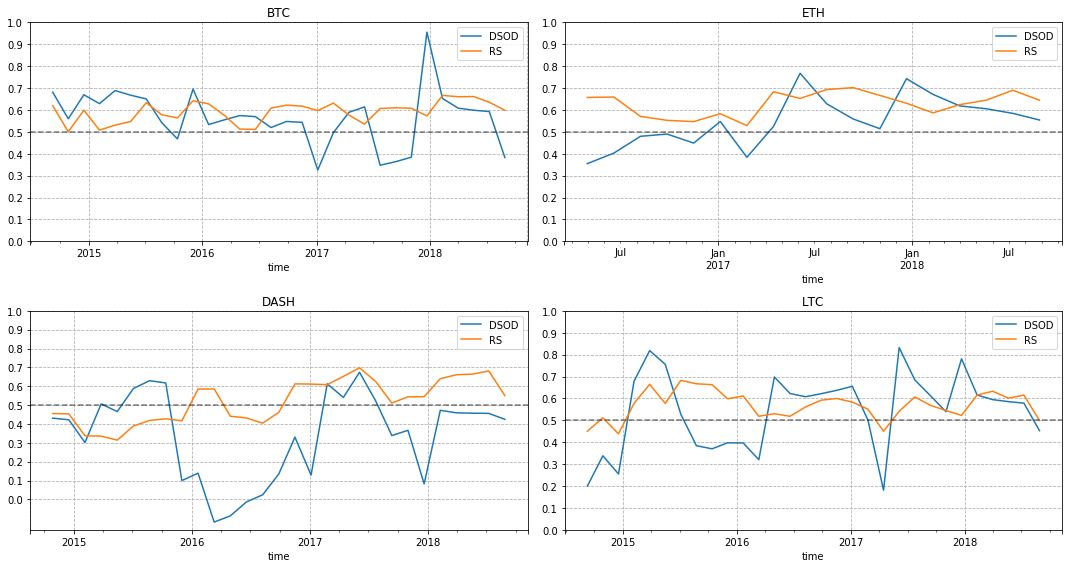

In [18]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [19]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-25  0.397661  0.593729  0.421779  0.568695  0.502827  0.598207   
2018-09-26  0.396723  0.594259  0.419255  0.569034  0.495790  0.596593   
2018-09-27  0.395850  0.593361  0.416081  0.568493  0.488328  0.594987   
2018-09-28  0.395307  0.591762  0.412809  0.567441  0.480922  0.593782   
2018-09-29  0.395635  0.590159  0.409800  0.565925  0.474020  0.592782   

                 LTC            
                DSOD        RS  
time                            
2018-09-25  0.435910  0.510880  
2018-09-26  0.435485  0.510333  
2018-09-27  0.434504  0.510868  
2018-09-28  0.433503  0.510630  
2018-09-29  0.432773  0.510483

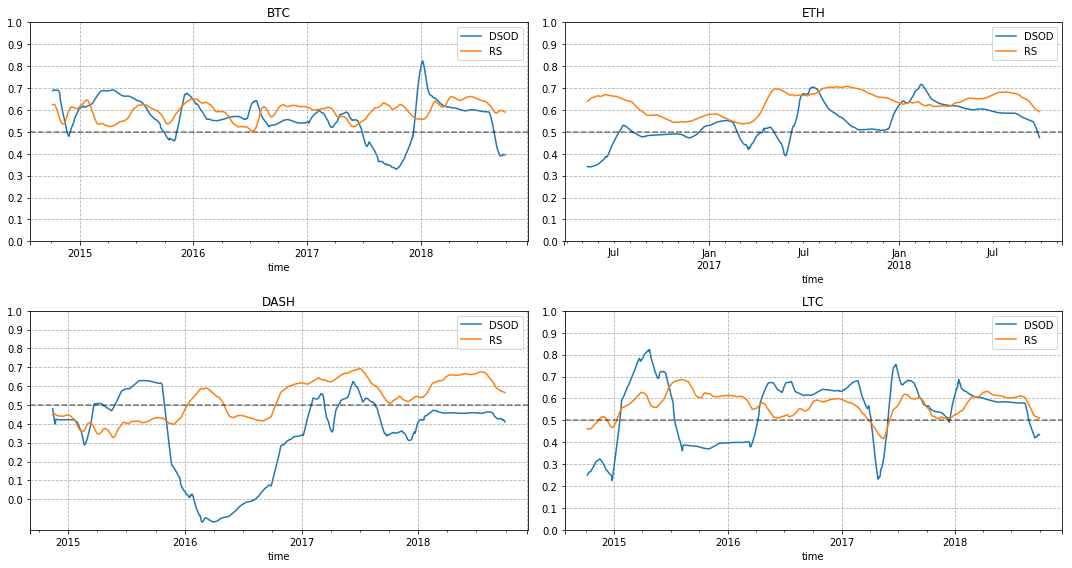

In [20]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [21]:
roll_hurst[::20].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-06-29  0.593270  0.647371  0.456561  0.681035  0.585870  0.674853   
2018-07-19  0.591858  0.651797  0.466546  0.634816  0.587887  0.676447   
2018-08-08  0.589538  0.601596  0.459752  0.611813  0.584841  0.668289   
2018-08-28  0.382779  0.598736  0.424454  0.550117  0.554240  0.644674   
2018-09-17  0.420036  0.574552  0.415597  0.591105  0.484816  0.568560   

                 LTC            
                DSOD        RS  
time                            
2018-06-29  0.578702  0.596575  
2018-07-19  0.579449  0.616869  
2018-08-08  0.579852  0.580711  
2018-08-28  0.452705  0.499244  
2018-09-17  0.399894  0.495532

In [22]:
roll_hurst[::20].mean()

BTC   DSOD    0.562306
      RS      0.594714
DASH  DSOD    0.341546
      RS      0.527341
ETH   DSOD    0.523452
      RS      0.629387
LTC   DSOD    0.537051
      RS      0.566113
dtype: float64

In [23]:
roll_hurst[::20].median()

BTC   DSOD    0.573946
      RS      0.601117
DASH  DSOD    0.423470
      RS      0.539672
ETH   DSOD    0.520113
      RS      0.639166
LTC   DSOD    0.579659
      RS      0.577123
dtype: float64

In [24]:
roll_hurst[::20].mean(level=0, axis=1);

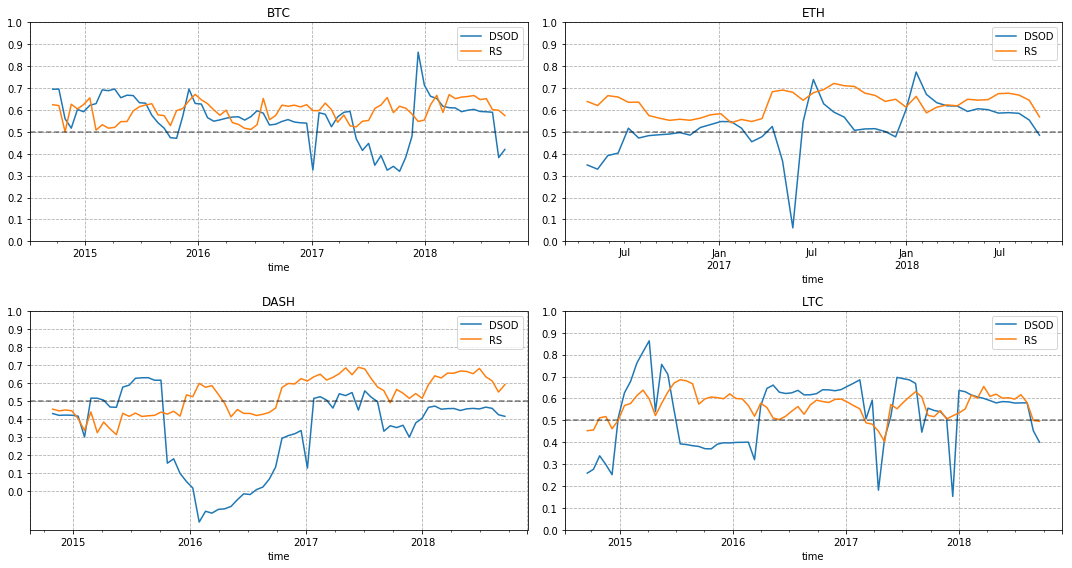

In [25]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [26]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-25  0.407821  0.589131  0.420350  0.572031  0.476284  0.580731   
2018-09-26  0.402996  0.587696  0.415479  0.571765  0.465380  0.577929   
2018-09-27  0.397925  0.585333  0.409032  0.569711  0.454387  0.576654   
2018-09-28  0.393059  0.580866  0.402766  0.566707  0.443443  0.576230   
2018-09-29  0.388790  0.576102  0.396963  0.562624  0.433338  0.576725   

                 LTC            
                DSOD        RS  
time                            
2018-09-25  0.428144  0.510758  
2018-09-26  0.426152  0.511743  
2018-09-27  0.423358  0.512328  
2018-09-28  0.421763  0.513412  
2018-09-29  0.420450  0.514036

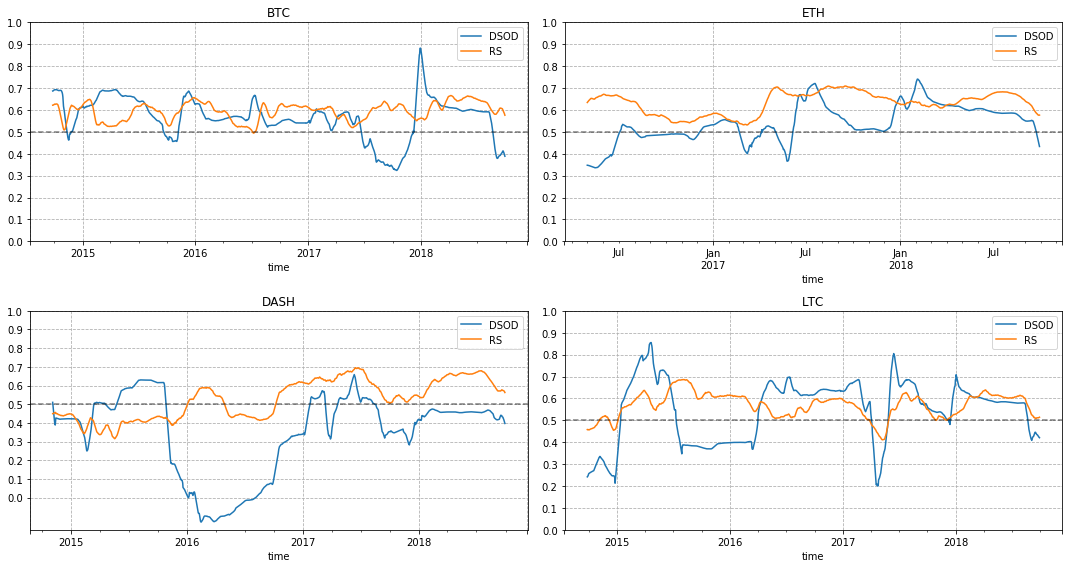

In [27]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [28]:
roll_hurst[::10].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-08-18  0.404795  0.572489  0.442738  0.585827  0.550614  0.642255   
2018-08-28  0.382779  0.598736  0.424454  0.550117  0.554240  0.644674   
2018-09-07  0.458018  0.619076  0.458155  0.574979  0.550243  0.622008   
2018-09-17  0.420036  0.574552  0.415597  0.591105  0.484816  0.568560   
2018-09-27  0.356587  0.571808  0.329225  0.533886  0.330376  0.596497   

                 LTC            
                DSOD        RS  
time                            
2018-08-18  0.393859  0.518541  
2018-08-28  0.452705  0.499244  
2018-09-07  0.479144  0.503579  
2018-09-17  0.399894  0.495532  
2018-09-27  0.423265  0.515279

In [29]:
roll_hurst[::10].mean()

BTC   DSOD    0.565107
      RS      0.594669
DASH  DSOD    0.348115
      RS      0.525142
ETH   DSOD    0.531760
      RS      0.630140
LTC   DSOD    0.541521
      RS      0.566803
dtype: float64

In [30]:
roll_hurst[::10].median()

BTC   DSOD    0.571800
      RS      0.601997
DASH  DSOD    0.424454
      RS      0.541645
ETH   DSOD    0.525381
      RS      0.643716
LTC   DSOD    0.583954
      RS      0.577177
dtype: float64

In [31]:
roll_hurst[::10].mean(level=0, axis=1);

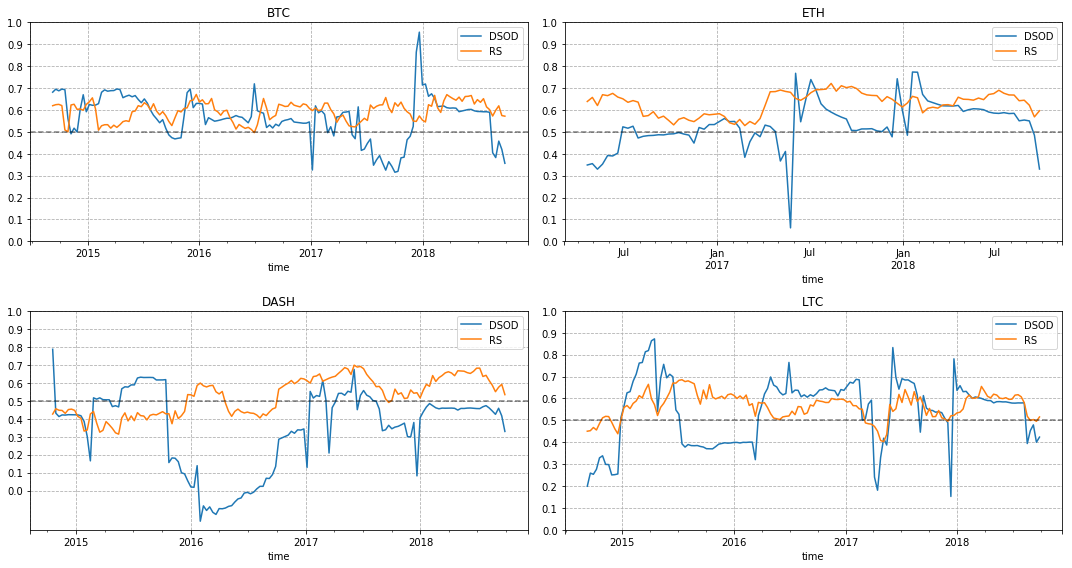

In [32]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [33]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-25  0.402102  0.564077  0.390076  0.564628  0.406316  0.566982   
2018-09-26  0.394495  0.565019  0.376157  0.564758  0.386007  0.569738   
2018-09-27  0.388150  0.564745  0.367520  0.559036  0.370563  0.572532   
2018-09-28  0.382975  0.560638  0.359387  0.552641  0.362353  0.578012   
2018-09-29  0.380037  0.555749  0.350884  0.543968  0.356077  0.582305   

                 LTC            
                DSOD        RS  
time                            
2018-09-25  0.416594  0.511959  
2018-09-26  0.415850  0.513546  
2018-09-27  0.418187  0.515521  
2018-09-28  0.420141  0.515553  
2018-09-29  0.422046  0.511801

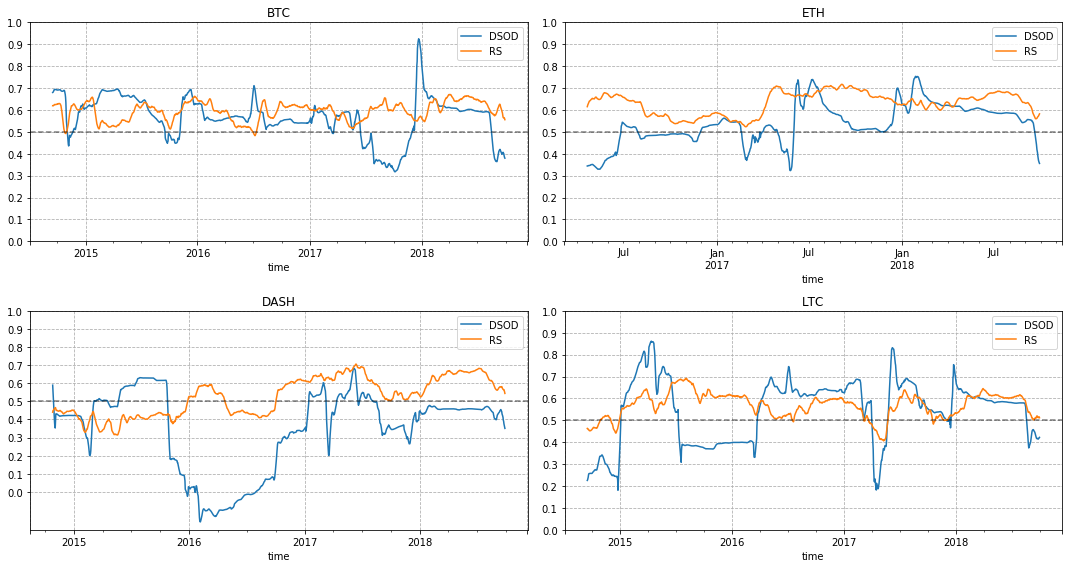

In [34]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
